In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pathlib
import numpy as np
from tensorflow.keras.preprocessing import image
from skimage.io import imread
import cv2 as cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Flatten,Dropout, Conv2D
from tensorflow.keras import Input
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [3]:
def load_image_paths(container_path):
    image_dir = pathlib.Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "A image classification dataset"
    image_paths = []
    flat_data = []
    target = []
    count = 0
    train_img_path = []
    train_label = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            count += 1
            train_img_path.append(str(file))
            train_label.append(categories[i])

    X = np.array(train_img_path)
    y = np.array(train_label)
    catStringArr = np.array(categories)

    return X, y, catStringArr


In [4]:
X = []
y = []
X, y, labelStringArr = load_image_paths("/home/pascal_steiger/Downloads/data/")
img_df = pd.DataFrame(zip(X, y), columns=["path", "label"])

print(labelStringArr)

img_df.sample(n=10)

['MKD' 'HRV' 'ISL' 'IRL' 'ITA' 'HUN' 'LVA' 'GBR' 'FRA' 'LTU' 'AUT' 'SVN'
 'FIN' 'ESP' 'NOR' 'BGR' 'PRT' 'SVK' 'BEL' 'EST' 'POL' 'CZE' 'NLD' 'CHE'
 'DNK' 'SWE']


,path,label
14168,/home/pascal_steiger/Downloads/data/ESP/img_ES...,ESP
12057,/home/pascal_steiger/Downloads/data/FIN/img_FI...,FIN
9274,/home/pascal_steiger/Downloads/data/LTU/img_LT...,LTU
16117,/home/pascal_steiger/Downloads/data/BGR/img_BG...,BGR
26077,/home/pascal_steiger/Downloads/data/SWE/img_SW...,SWE
21108,/home/pascal_steiger/Downloads/data/POL/img_PO...,POL
25394,/home/pascal_steiger/Downloads/data/DNK/img_DN...,DNK
21760,/home/pascal_steiger/Downloads/data/CZE/img_CZ...,CZE
23513,/home/pascal_steiger/Downloads/data/NLD/img_52...,NLD
11014,/home/pascal_steiger/Downloads/data/AUT/img_AU...,AUT


In [5]:
train_df, test_df = train_test_split(img_df, shuffle=True, test_size=0.2, random_state=42)


print(train_df.sample(n=5))
print(train_df.shape)
print(test_df.sample(n=5))
print(test_df.shape)


                                                    path label
17199  /home/pascal_steiger/Downloads/data/PRT/img_PR...   PRT
25762  /home/pascal_steiger/Downloads/data/SWE/img_SW...   SWE
5962   /home/pascal_steiger/Downloads/data/HUN/img_HU...   HUN
21992  /home/pascal_steiger/Downloads/data/CZE/img_CZ...   CZE
5736   /home/pascal_steiger/Downloads/data/HUN/img_HU...   HUN
(21234, 2)
                                                    path label
1255   /home/pascal_steiger/Downloads/data/HRV/img_HR...   HRV
9736   /home/pascal_steiger/Downloads/data/LTU/img_LT...   LTU
2516   /home/pascal_steiger/Downloads/data/ISL/img_IS...   ISL
20897  /home/pascal_steiger/Downloads/data/POL/img_PO...   POL
2870   /home/pascal_steiger/Downloads/data/ISL/img_IS...   ISL
(5309, 2)


In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col="path",
        y_col="label",
        target_size=(299, 299),
        batch_size=32,
        class_mode="sparse",
        seed=42
)


validation_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col="path",
        y_col="label",
        target_size=(299, 299),
        batch_size=32,
        class_mode="sparse",
        shuffle=False
)

Found 21234 validated image filenames belonging to 26 classes.
Found 5309 validated image filenames belonging to 26 classes.


In [9]:
with tf.device("/device:GPU:0"):
    from tensorflow.keras.applications.xception import Xception
    tl_xcep = Xception(include_top=True,weights="imagenet")
    tl_xcep = tf.keras.Model(tl_xcep.input, tl_xcep.layers[-3].output)
    
    for layer in tl_xcep.layers:
        layer.trainable = False

    for layer in tl_xcep.layers[-26:]:
        layer.trainable = True 
    print(tl_xcep.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [10]:
with tf.device("/device:GPU:0"):

    I = Input(shape=(299, 299, 3))



    x = tl_xcep(I)
    
    conv2d = Conv2D(10, 10, activation='relu', padding="same")(x)

    flat= Flatten()(conv2d)


    dense = Dense(4096, activation='relu', name='denserelu')(flat)
    
    dropout = Dropout(0.3)(dense)

    dense2 = Dense(2048, activation='relu', name='denserelu2')(dropout)
    
    dropout2 = Dropout(0.1)(dense2)

    dense3 = Dense(26, activation='softmax', name='my_dense')(dropout2)

    #prediction = Dense(26, activation='softmax', name='prediction')



    #out2 = prediction(x)


    new_model2 = tf.keras.Model(I, dense3)

    new_model2.summary()





Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
model_1 (Functional)         (None, 10, 10, 2048)      20861480  
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 10, 10, 10)        2048010   
_________________________________________________________________
flatten (Flatten)            (None, 1000)              0         
_________________________________________________________________
denserelu (Dense)            (None, 4096)              4100096   
_________________________________________________________________
dropout (Dropout)            (None, 4096)              0         
_________________________________________________________________
denserelu2 (Dense)           (None, 2048)              8390

In [12]:
def unwrap_model(model):
    mdl = model.get_layer('model_1')
    inp = mdl.input
    out = model.get_layer('conv2d_8')(mdl.output)
    out = model.get_layer('flatten')(out)
    out = model.get_layer('denserelu')(out)
    out = model.get_layer('dropout')(out)
    out = model.get_layer('denserelu2')(out)
    out = model.get_layer('dropout_1')(out)
    out = model.get_layer('my_dense')(out)    
    return tf.keras.Model(inp, out)   
    
new_model2 = unwrap_model(new_model2)
new_model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [13]:
# define callbacks for early stopping

early_stopping = EarlyStopping(
    monitor='val_sparse_categorical_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_sparse_categorical_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [14]:
with tf.device("/device:GPU:0"):
    new_model2.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

with tf.device("/device:GPU:0"):
    history = new_model2.fit(
          train_generator,
          epochs=200,
          verbose = 1,
          callbacks=callbacks,
          #steps_per_epoch=2000 // 32,
          validation_data=validation_generator)
    new_model2.save('CNN-TL_xcep_v3.h5')

Epoch 1/200
664/664 [==============================] - 567s 841ms/step - loss: 3.2475 - sparse_categorical_accuracy: 0.0632 - val_loss: 3.0489 - val_sparse_categorical_accuracy: 0.1010
Epoch 2/200
664/664 [==============================] - 548s 825ms/step - loss: 2.9952 - sparse_categorical_accuracy: 0.1036 - val_loss: 2.8997 - val_sparse_categorical_accuracy: 0.1164
Epoch 3/200
664/664 [==============================] - 546s 821ms/step - loss: 2.7877 - sparse_categorical_accuracy: 0.1491 - val_loss: 2.7938 - val_sparse_categorical_accuracy: 0.1573
Epoch 4/200
664/664 [==============================] - 543s 817ms/step - loss: 2.6303 - sparse_categorical_accuracy: 0.1853 - val_loss: 2.4897 - val_sparse_categorical_accuracy: 0.2238
Epoch 5/200
664/664 [==============================] - 538s 809ms/step - loss: 2.5210 - sparse_categorical_accuracy: 0.2089 - val_loss: 2.4652 - val_sparse_categorical_accuracy: 0.2364
Epoch 6/200
664/664 [==============================] - 536s 807ms/step - lo

Epoch 45/200
664/664 [==============================] - 534s 804ms/step - loss: 0.2802 - sparse_categorical_accuracy: 0.9066 - val_loss: 3.6868 - val_sparse_categorical_accuracy: 0.4140
Epoch 46/200
664/664 [==============================] - 533s 802ms/step - loss: 0.2785 - sparse_categorical_accuracy: 0.9079 - val_loss: 3.3152 - val_sparse_categorical_accuracy: 0.4325
Epoch 47/200
664/664 [==============================] - 533s 803ms/step - loss: 0.2595 - sparse_categorical_accuracy: 0.9124 - val_loss: 3.6279 - val_sparse_categorical_accuracy: 0.4231
Epoch 48/200
664/664 [==============================] - 532s 802ms/step - loss: 0.2589 - sparse_categorical_accuracy: 0.9124 - val_loss: 3.5580 - val_sparse_categorical_accuracy: 0.4328
Epoch 49/200
664/664 [==============================] - 536s 807ms/step - loss: 0.2510 - sparse_categorical_accuracy: 0.9166 - val_loss: 3.4073 - val_sparse_categorical_accuracy: 0.4377
Epoch 50/200
664/664 [==============================] - 538s 810ms/ste

/home/pascal_steiger/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


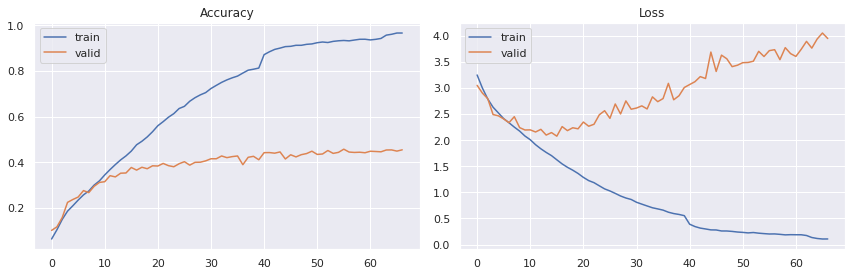

In [15]:
# plot training and validation metrics

sns.set()
fig = plt.figure(0, (12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history.epoch, y=history.history['sparse_categorical_accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_sparse_categorical_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.savefig('CNN(299,299)-tl_xcepv3.png')

plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        "/mnt/data/testing3/",
        target_size=(224, 224),
        batch_size=1,
        class_mode='sparse',
        shuffle=False)

res=validmodel2.predict(test_generator, steps=len(test_generator), verbose=1)
y_classes = res.argmax(axis=-1)
print(labelStringArr)
label2 = np.sort(labelStringArr)
print(label2)
print(y_classes)

filenames=test_generator.filenames
label_map = (train_generator.class_indices)
print(label_map)
preds = []
labels = []
for i in range(len(filenames)):
    #print(res[i])
    preds.append(res[i][np.argmax(res[i])])
    labels.append(label2[y_classes[i]])




# Data frame
results=pd.DataFrame({"file":filenames, "class":labels, "pr":preds})

results.to_csv("res2.csv", index = False)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
num_of_test_samples=5309
batch_size=32
Y_pred = validmodel2.predict_generator(validation_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = label2
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))